# 2024 OIBC Challenge
**(Deep Learning version final)**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import os
from datetime import datetime, timedelta

import torch
from torch.utils.data import DataLoader
from DL_final import NeuralNetwork, ElecDataset, train

## 데이터 전처리

In [2]:
print(os.getcwd())  # 현재 작업 경로 출력

f:\For me\Project\24-OIBC-WolgoksTears\personal_files\hoon


actual_weather_1

In [3]:
# 데이터 불러오기
actual_weather_1 = pd.read_csv("../../data_files/actual_weather_1.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
actual_weather_1['datetime'] = pd.to_datetime(actual_weather_1['ts'], unit='s')
actual_weather_1['datetime'] = actual_weather_1['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거
actual_weather_1.drop(columns=['ts'], inplace=True)
actual_weather_1.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
actual_weather_1 = actual_weather_1.groupby(['datetime'], as_index=False).mean()


# weather_forecast에 없는 columns 제거
actual_weather_1.drop(columns=['real_feel_temp_shade'], inplace=True)
actual_weather_1.drop(columns=['pressure'], inplace=True)
actual_weather_1.drop(columns=['appr_temp'], inplace=True)
actual_weather_1.drop(columns=['wind_chill_temp'], inplace=True)
 
# 결과 확인
actual_weather_1.head()

,datetime,temp,real_feel_temp,rel_hum,dew_point,wind_dir,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,wet_bulb_temp,precip_1h
0,2024-03-01 00:00:00,8.500000,8.000000,81.000000,5.500000,270.000000,6.100000,17.600000,0.0,20.900000,91.000000,579.000000,7.100000,0.100000
1,2024-03-01 01:00:00,7.158333,3.041667,72.666667,2.508333,234.666667,20.483333,26.366667,0.0,20.783333,97.750000,693.416667,5.091667,0.008333
2,2024-03-01 02:00:00,6.477778,2.111111,75.666667,2.433333,262.888889,21.944444,27.433333,0.0,20.033333,86.333333,616.222222,4.733333,0.011111
3,2024-03-01 03:00:00,6.045455,0.900000,74.545455,1.663636,213.000000,22.490909,27.645455,0.0,19.900000,62.818182,8692.363636,4.209091,0.136364
4,2024-03-01 04:00:00,5.430000,-0.090000,68.100000,-0.030000,256.800000,26.140000,42.440000,0.0,23.800000,38.100000,10911.800000,3.180000,0.410000


weather_forecast_1

In [4]:
# 데이터 불러오기
weather_forecast_1 = pd.read_csv("../../data_files/weather_forecast_1.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
weather_forecast_1['datetime'] = pd.to_datetime(weather_forecast_1['ts'], unit='s')
weather_forecast_1['datetime'] = weather_forecast_1['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열 제거, 'base_ts' 열 제거, 'location' 제거
weather_forecast_1.drop(columns=['ts'], inplace=True)
weather_forecast_1.drop(columns=['base_ts'], inplace=True)
weather_forecast_1.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
weather_forecast_1 = weather_forecast_1.groupby(['datetime'], as_index=False).mean()


# 예보 데이터의 columns 순서를 actual_weather columns 순서와 맞추기
weather_forecast_1 = weather_forecast_1[['datetime', 'temp', 'real_feel_temp', 'rel_hum',
       'dew_point', 'wind_dir', 'wind_spd', 'wind_gust_spd', 'uv_idx', 'vis',
       'cld_cvr', 'ceiling', 'wet_bulb_temp', 'total_liq']]
weather_forecast_1['precip_1h'] = weather_forecast_1['total_liq']
weather_forecast_1.drop(columns=['total_liq'], inplace=True)  

# 결과 확인
weather_forecast_1.head()

,datetime,temp,real_feel_temp,rel_hum,dew_point,wind_dir,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,wet_bulb_temp,precip_1h
0,2024-03-02 00:00:00,1.728394,-4.320987,64.333333,-4.320987,335.555556,22.048022,50.604944,0.0,16.093400,75.555556,1700.106667,-0.555556,0.000000
1,2024-03-02 01:00:00,1.851852,-4.506173,64.333333,-4.135800,335.000000,22.048022,50.640711,0.0,15.378140,84.777778,1249.680000,-0.432099,0.056444
2,2024-03-02 02:00:00,1.790123,-5.061728,66.333333,-3.950616,334.444444,22.656000,51.481144,0.0,14.392882,89.333333,1229.360000,-0.370370,0.197556
3,2024-03-02 03:00:00,1.604940,-5.308640,67.333333,-3.888887,333.777778,23.263967,51.463267,0.0,15.195758,94.555556,1933.786667,-0.370370,0.084667
4,2024-03-02 04:00:00,1.851852,-4.876541,66.444444,-3.950616,333.888889,23.871922,50.837400,0.0,15.825200,82.555556,2600.960000,-0.308642,0.000000


actual_weather_2

In [5]:
# 데이터 불러오기
actual_weather_2 = pd.read_csv("../../data_files/actual_weather_2.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
actual_weather_2['datetime'] = pd.to_datetime(actual_weather_2['ts'], unit='s')
actual_weather_2['datetime'] = actual_weather_2['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거
actual_weather_2.drop(columns=['ts'], inplace=True)
actual_weather_2.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
actual_weather_2 = actual_weather_2.groupby(['datetime'], as_index=False).mean()
 
# 결과 확인
actual_weather_2.head()

,datetime,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow
0,2024-03-01 00:00:00,89.333333,6.146667,6.146667,6.146667,74.666667,1022.666667,8.553333,345.333333,0.17,0.0
1,2024-03-01 01:00:00,83.500000,6.255000,6.255000,6.255000,70.500000,1022.500000,6.256667,342.000000,0.00,0.0
2,2024-03-01 02:00:00,84.333333,5.926667,5.926667,5.926667,67.833333,1022.833333,7.291667,343.000000,0.21,0.0
3,2024-03-01 03:00:00,83.666667,5.198333,5.198333,5.198333,63.833333,1023.500000,7.520000,342.333333,0.00,0.0
4,2024-03-01 04:00:00,42.166667,4.433333,4.433333,4.433333,64.833333,1023.833333,7.330000,342.000000,0.00,0.0


weather_forecast_2

In [6]:
# 데이터 불러오기
weather_forecast_2 = pd.read_csv("../../data_files/weather_forecast_2.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
weather_forecast_2['datetime'] = pd.to_datetime(weather_forecast_2['ts'], unit='s')
weather_forecast_2['datetime'] = weather_forecast_2['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거, 'base_ts' 제거
weather_forecast_2.drop(columns=['ts'], inplace=True)
weather_forecast_2.drop(columns=['location'], inplace=True)
weather_forecast_2.drop(columns=['base_ts'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
weather_forecast_2 = weather_forecast_2.groupby(['datetime'], as_index=False).mean()
 
# 결과 확인
weather_forecast_2.head()

,datetime,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow
0,2024-03-02 00:00:00,100.000000,1.213333,1.213333,1.213333,60.333333,1027.000000,8.306667,332.333333,0.0,0.0
1,2024-03-02 01:00:00,100.000000,1.280000,1.280000,1.280000,61.000000,1027.000000,8.043333,333.666667,0.0,0.0
2,2024-03-02 02:00:00,100.000000,1.323333,1.323333,1.323333,60.666667,1026.666667,7.626667,333.000000,0.0,0.0
3,2024-03-02 03:00:00,100.000000,1.323333,1.323333,1.323333,60.666667,1026.000000,7.310000,332.666667,0.0,0.0
4,2024-03-02 04:00:00,96.333333,1.356667,1.356667,1.356667,60.666667,1026.000000,7.076667,331.666667,0.0,0.0


elec_supply

In [7]:
# 데이터 불러오기
elec_supply = pd.read_csv("../../data_files/elec_supply.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
elec_supply['datetime'] = pd.to_datetime(elec_supply['ts'], unit='s')
elec_supply['datetime'] = elec_supply['datetime'].dt.round('h') + timedelta(hours=9)

# 1시간 단위로 그룹화하여 평균을 계산
elec_supply = elec_supply.groupby(['datetime'], as_index=False).mean()

# 결과 확인
elec_supply.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
elec_supply.head()

,datetime,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW)
0,2024-01-01 00:00:00,1.285000e+06,757500.000000,0.0,115593.233333,123350.666667,527166.666667,328500.000000
1,2024-01-01 01:00:00,1.238308e+06,727538.461538,0.0,68802.153846,77036.569231,510692.307692,312692.307692
2,2024-01-01 02:00:00,1.214818e+06,694090.909091,0.0,45923.181818,53740.109091,520727.272727,318545.454545
3,2024-01-01 03:00:00,1.207923e+06,672000.000000,0.0,38567.161538,46614.815385,536000.000000,291000.000000
4,2024-01-01 04:00:00,1.192364e+06,666000.000000,0.0,22849.272727,30575.990909,526363.636364,318272.727273


smp_da

In [8]:
# 데이터 불러오기
smp_da = pd.read_csv("../../data_files/smp_da.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
smp_da['datetime'] = pd.to_datetime(smp_da['ts'], unit='s') + timedelta(hours=9)

# 결과 확인
smp_da.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
smp_da.head()

,하루전가격(원/kWh),datetime
0,107.39,2024-03-01 00:00:00
1,107.39,2024-03-01 01:00:00
2,95.30,2024-03-01 02:00:00
3,87.89,2024-03-01 03:00:00
4,0.00,2024-03-01 04:00:00


smp_rt_rc

In [9]:
# 데이터 불러오기
smp_rt_rc = pd.read_csv("../../data_files/smp_rt_rc.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
smp_rt_rc['datetime'] = pd.to_datetime(smp_rt_rc['ts'], unit='s')
smp_rt_rc['datetime'] = smp_rt_rc['datetime'].dt.round('h') + timedelta(hours=9)

# 1시간 단위로 그룹화하여 평균을 계산
smp_rt_rc = smp_rt_rc.groupby(['datetime'], as_index=False).mean()

# 결과 확인
smp_rt_rc.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
smp_rt_rc.head()

,datetime,실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh)
0,2024-03-01 00:00:00,133.125,133.125
1,2024-03-01 01:00:00,115.160,115.160
2,2024-03-01 02:00:00,92.830,92.830
3,2024-03-01 03:00:00,87.334,87.334
4,2024-03-01 04:00:00,87.260,87.260


##### X 데이터

- 제주 기상 실측_1 (n+1)
- 제주 기상 실측_2 (n+1)
- 하루 전 시장 전기 예측 (n)
- 제주 전력 시장 실시간 (n-1)
- 제주 전력 시장 현황 (n-1)

In [10]:
actual_weather_1
actual_weather_2
weather_forecast_1
weather_forecast_2
smp_da_x = smp_da.copy()
smp_da_x['datetime'] += pd.Timedelta(days=1)
smp_rt_rc['datetime'] += pd.Timedelta(days=2)
elec_supply['datetime'] += pd.Timedelta(days=2)

In [11]:
dfs = [actual_weather_1, actual_weather_2, smp_da_x, smp_rt_rc, elec_supply]

X = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dfs)

##### Y 데이터

- 하루 전 시장 전기 예측 가격(n+1)

In [12]:
Y = smp_da

##### 날짜 설정

In [13]:
target_date = {
  # 최소 2024-03-04
  "train_start_date": '2024-03-03',
  # 최대 2024-10-22
  "train_end_date": '2024-10-22',
}

In [14]:
X = X.loc[
  (X['datetime'] > target_date['train_start_date']) &
  (X['datetime'] <= target_date['train_end_date'])
]

In [15]:
Y = Y.loc[
  (Y['datetime'] > target_date['train_start_date']) &
  (Y['datetime'] <= target_date['train_end_date'])
]

In [16]:
targ = datetime.strptime(target_date['train_start_date'], '%Y-%m-%d') + timedelta(hours=1)
endd = datetime.strptime(target_date['train_end_date'], '%Y-%m-%d')

In [17]:
# X 데이터의 특정 시간이 누락되었기 때문에
# Y 데이터에서도 누락된 시간대를 제거한다.

while targ <= endd:
  if not len(X.loc[X['datetime'] == targ]):
    idx = Y[Y['datetime'] == targ].index
    Y.drop(idx, inplace=True)
  
  targ = targ + timedelta(hours=1)

데이터 확인

In [18]:
X.head()

,datetime,temp_x,real_feel_temp,rel_hum,dew_point,wind_dir_x,wind_spd,wind_gust_spd,uv_idx,vis,...,하루전가격(원/kWh),실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh),공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW)
1441,2024-03-03 01:00:00,4.962500,1.650000,56.125000,-3.112500,246.375000,16.912500,24.993750,0.0,25.937500,...,138.50,115.160,115.160,1.367154e+06,764692.307692,0.0,213928.384615,229070.230769,602692.307692,279846.153846
1442,2024-03-03 02:00:00,4.836364,0.918182,57.727273,-2.918182,245.727273,18.227273,22.754545,0.0,25.027273,...,99.48,92.830,92.830,1.389455e+06,736818.181818,0.0,234674.181818,249718.181818,652636.363636,328090.909091
1443,2024-03-03 03:00:00,4.666667,1.811111,57.777778,-3.011111,250.222222,15.344444,20.266667,0.0,23.255556,...,95.38,87.334,87.334,1.370923e+06,733461.538462,0.0,216275.153846,231237.153846,637384.615385,312538.461538
1444,2024-03-03 04:00:00,4.910000,1.240000,58.400000,-2.670000,256.600000,18.270000,28.230000,0.0,26.060000,...,91.24,87.260,87.260,1.378545e+06,744000.000000,0.0,223340.090909,238393.363636,634818.181818,309636.363636
1445,2024-03-03 05:00:00,5.516667,2.708333,56.833333,-2.525000,257.083333,16.166667,19.816667,0.0,22.541667,...,91.24,93.352,93.352,1.391462e+06,756538.461538,0.0,235738.000000,250772.615385,634923.076923,308615.384615


In [19]:
len(X), len(Y)

(5592, 5592)

## 파이토치 모델 학습

### 모델 구성

In [20]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

NVIDIA GeForce GTX 1650
2.5.0+cu118
11.8
tensor([0.5791], device='cuda:0')


device(type='cuda', index=0)

##### Dataset & dataloader 구성

In [21]:
dataset = ElecDataset(X, Y)

dataloader = DataLoader(dataset=dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=False)

### Custom Loss

In [22]:
def customloss(predict, y):#학습용
    predict = predict.squeeze()

    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y, dtype=torch.bool)

    positive_mask = y > 0
    negative_mask = y <= 0

    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y < -1  # y <= 0인 부분 마스크
    e2_adjusted_mask = (y <= 0) & (y >= -1)
    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs((y[e1_mask] - predict[e1_mask]) / (y[e1_mask]))
    e2[e2_mask] = torch.abs((y[e2_mask] - predict[e2_mask]) / (-y[e2_mask]))
    e2[e2_adjusted_mask] = torch.abs((y[e2_adjusted_mask] - predict[e2_adjusted_mask]) / (-1))

    accuracy[positive_mask] = (predict[positive_mask] > 0)
    accuracy[negative_mask] = (predict[negative_mask] <= 0)

    e1_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)

    accuracy_mean = accuracy.float().mean()

    e_F = 0.2 * e1_mean + 0.8 * e2_mean - (accuracy_mean - 0.95)
    if e_F<0:
      e_F=0
    e_F_square = e_F**2
    mse_loss = torch.mean((y - predict)**2)

    loss_new = 0
    if predict.mean()>140:
      loss_new += predict.mean()-140

    loss_new = loss_new ** 2

    return e_F_square*10+mse_loss+loss_new

### 학습

##### 하이퍼 파라미터

In [23]:
learning_rate = 0.0003
epoches=100

input_size = len(X.columns) - 1  # Number of input features
output_size = 1  # Single output

model = NeuralNetwork(input_size, output_size)

criterion = customloss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
model, train_history = train(model, dataloader, criterion, optimizer, epoches, device)

100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 15.43it/s]


Epoch [1/100], Loss: 14365.0459


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.96it/s]


Epoch [2/100], Loss: 11300.8253


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.94it/s]


Epoch [3/100], Loss: 7742.6525


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.67it/s]


Epoch [4/100], Loss: 7107.5915


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.52it/s]


Epoch [5/100], Loss: 5677.4609


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.28it/s]


Epoch [6/100], Loss: 4679.8305


100%|█████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.44it/s]


Epoch [7/100], Loss: 5898.1618


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.74it/s]


Epoch [8/100], Loss: 5516.3445


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.62it/s]


Epoch [9/100], Loss: 5231.8939


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.59it/s]


Epoch [10/100], Loss: 4262.7460


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.05it/s]


Epoch [11/100], Loss: 3910.5467


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.78it/s]


Epoch [12/100], Loss: 3895.1104


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.38it/s]


Epoch [13/100], Loss: 3928.5284


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.60it/s]


Epoch [14/100], Loss: 3531.6598


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.71it/s]


Epoch [15/100], Loss: 3801.4162


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.92it/s]


Epoch [16/100], Loss: 3234.7421


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.48it/s]


Epoch [17/100], Loss: 3664.4216


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.77it/s]


Epoch [18/100], Loss: 4269.7112


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.72it/s]


Epoch [19/100], Loss: 3202.6370


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.19it/s]


Epoch [20/100], Loss: 3531.9074


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.51it/s]


Epoch [21/100], Loss: 3575.0356


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.83it/s]


Epoch [22/100], Loss: 2579.5428


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.73it/s]


Epoch [23/100], Loss: 2830.4418


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.45it/s]


Epoch [24/100], Loss: 3534.4492


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.77it/s]


Epoch [25/100], Loss: 2918.7400


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.60it/s]


Epoch [26/100], Loss: 2286.7955


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.77it/s]


Epoch [27/100], Loss: 3193.7553


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.83it/s]


Epoch [28/100], Loss: 2896.9069


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.97it/s]


Epoch [29/100], Loss: 3609.8849


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.70it/s]


Epoch [30/100], Loss: 3566.1689


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.87it/s]


Epoch [31/100], Loss: 2257.3104


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.94it/s]


Epoch [32/100], Loss: 2874.6504


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.81it/s]


Epoch [33/100], Loss: 2643.2239


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.98it/s]


Epoch [34/100], Loss: 2819.4951


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.83it/s]


Epoch [35/100], Loss: 2807.4831


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.99it/s]


Epoch [36/100], Loss: 2372.2694


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.72it/s]


Epoch [37/100], Loss: 2802.2642


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.67it/s]


Epoch [38/100], Loss: 3318.0511


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.75it/s]


Epoch [39/100], Loss: 2547.8286


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.62it/s]


Epoch [40/100], Loss: 2511.9983


100%|█████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 14.59it/s]


Epoch [41/100], Loss: 2783.4555


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.55it/s]


Epoch [42/100], Loss: 2795.1616


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.34it/s]


Epoch [43/100], Loss: 2071.1391


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.20it/s]


Epoch [44/100], Loss: 1929.7665


100%|█████████████████████████████████████████████████████████████| 175/175 [00:13<00:00, 13.29it/s]


Epoch [45/100], Loss: 2265.2255


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.50it/s]


Epoch [46/100], Loss: 1897.3603


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.92it/s]


Epoch [47/100], Loss: 2335.4635


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.09it/s]


Epoch [48/100], Loss: 2865.2130


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.20it/s]


Epoch [49/100], Loss: 2321.0390


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.78it/s]


Epoch [50/100], Loss: 2330.0004


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.96it/s]


Epoch [51/100], Loss: 1873.7334


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.50it/s]


Epoch [52/100], Loss: 1829.5154


100%|█████████████████████████████████████████████████████████████| 175/175 [00:13<00:00, 13.32it/s]


Epoch [53/100], Loss: 1821.9883


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.84it/s]


Epoch [54/100], Loss: 2264.6742


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.86it/s]


Epoch [55/100], Loss: 1835.9575


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.50it/s]


Epoch [56/100], Loss: 1671.6462


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.64it/s]


Epoch [57/100], Loss: 2073.0063


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.77it/s]


Epoch [58/100], Loss: 1630.4615


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.13it/s]


Epoch [59/100], Loss: 2775.1603


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.67it/s]


Epoch [60/100], Loss: 1929.1236


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.62it/s]


Epoch [61/100], Loss: 2309.3421


100%|█████████████████████████████████████████████████████████████| 175/175 [00:13<00:00, 13.44it/s]


Epoch [62/100], Loss: 1759.3669


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.74it/s]


Epoch [63/100], Loss: 1818.4082


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.61it/s]


Epoch [64/100], Loss: 1784.2979


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.82it/s]


Epoch [65/100], Loss: 2443.2325


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.83it/s]


Epoch [66/100], Loss: 1641.4155


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.70it/s]


Epoch [67/100], Loss: 1773.2662


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.63it/s]


Epoch [68/100], Loss: 3377.8131


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.96it/s]


Epoch [69/100], Loss: 2245.9132


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.78it/s]


Epoch [70/100], Loss: 1727.4282


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.90it/s]


Epoch [71/100], Loss: 1770.1537


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.90it/s]


Epoch [72/100], Loss: 1831.8607


100%|█████████████████████████████████████████████████████████████| 175/175 [00:13<00:00, 13.32it/s]


Epoch [73/100], Loss: 1510.8001


100%|█████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.18it/s]


Epoch [74/100], Loss: 2374.6514


100%|█████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.17it/s]


Epoch [75/100], Loss: 1625.2415


100%|█████████████████████████████████████████████████████████████| 175/175 [00:13<00:00, 13.41it/s]


Epoch [76/100], Loss: 1447.8357


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.62it/s]


Epoch [77/100], Loss: 1604.0397


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.03it/s]


Epoch [78/100], Loss: 1339.2291


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.33it/s]


Epoch [79/100], Loss: 1544.0472


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.10it/s]


Epoch [80/100], Loss: 2505.1995


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.07it/s]


Epoch [81/100], Loss: 2303.5560


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.28it/s]


Epoch [82/100], Loss: 1782.6370


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.46it/s]


Epoch [83/100], Loss: 2135.9339


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.40it/s]


Epoch [84/100], Loss: 2551.0791


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.19it/s]


Epoch [85/100], Loss: 1616.6543


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.50it/s]


Epoch [86/100], Loss: 1412.3373


100%|█████████████████████████████████████████████████████████████| 175/175 [00:13<00:00, 13.15it/s]


Epoch [87/100], Loss: 2673.7913


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.21it/s]


Epoch [88/100], Loss: 1457.2621


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.28it/s]


Epoch [89/100], Loss: 1393.6382


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.13it/s]


Epoch [90/100], Loss: 1447.6331


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.25it/s]


Epoch [91/100], Loss: 1266.8492


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.07it/s]


Epoch [92/100], Loss: 1360.2419


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.25it/s]


Epoch [93/100], Loss: 1389.2076


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.31it/s]


Epoch [94/100], Loss: 1595.5813


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.27it/s]


Epoch [95/100], Loss: 1492.3131


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.27it/s]


Epoch [96/100], Loss: 1495.1030


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 13.72it/s]


Epoch [97/100], Loss: 2342.7316


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.04it/s]


Epoch [98/100], Loss: 1406.0144


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.12it/s]


Epoch [99/100], Loss: 1351.4846


100%|█████████████████████████████████████████████████████████████| 175/175 [00:12<00:00, 14.19it/s]

Epoch [100/100], Loss: 1499.8319
Training complete.


##### 학습 loss

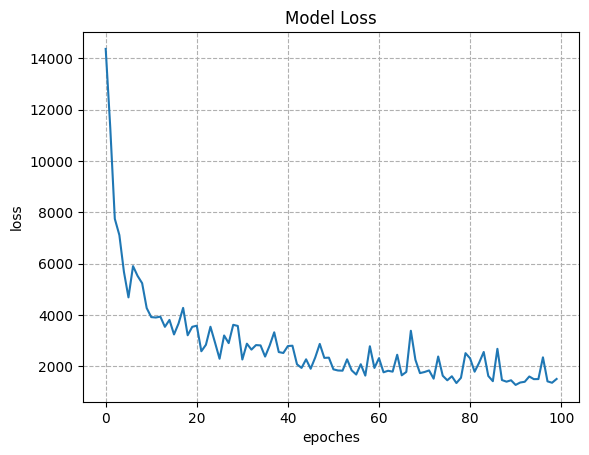

In [29]:
plt.plot(train_history)

plt.title('Model Loss')
plt.xlabel('epoches')
plt.ylabel('loss')
plt.grid(True, linestyle='--')

plt.show()

### 모델 저장

In [30]:
torch.save(model.state_dict(), 'smp_model.pth')